# Query 10
0. Exact result
1. Stratified sampling
2. Weighted KDE
3. Effect of the number of groups

In [ ]:
select
	c_custkey,
	c_name,
	sum(l_extendedprice * (1 - l_discount)) as revenue,
	c_acctbal,
	n_name,
	c_address,
	c_phone,
	c_comment
from
	customer,
	orders,
	lineitem,
	nation
where
	c_custkey = o_custkey
	and l_orderkey = o_orderkey
	and o_orderdate >= date ':1'
	and o_orderdate < date ':1' + interval '3' month
	and l_returnflag = 'R'
	and c_nationkey = n_nationkey
group by
	c_custkey,
	c_name,
	c_acctbal,
	c_phone,
	n_name,
	c_address,
	c_comment
order by
	revenue desc;

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

from collections import Counter

import scipy
from scipy.stats import gaussian_kde
from scipy import integrate

import timeit
import pickle
from datetime import date, timedelta
import sys
import scipy.stats as st
from random import random

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark import broadcast
# To avoid OverflowError: cannot serialize a string larger than 4GiB
def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[32]").setAll([
                                   ('spark.executor.memory', '4g'),  # find
                                   ('spark.driver.memory','10g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import stratified_sampling

In [5]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet")#.limit(3000)
nation = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/nation.parquet")#.limit(3000)
customer = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/customer.parquet")#.limit(3000)
orders = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/order.parquet")#.limit(3000)

### Helper Functions

In [6]:
CONSTRUCTION_TIME = [0] * 2
EXECUTION_TIME = [0] * 2
SPACE = [0] * 2
ERROR = [0] * 2

In [7]:
THE_DATE = date(1994, 12, 4)
QCS = ['c_custkey','c_name','c_acctbal','c_phone','n_name','c_address','c_comment', 'o_orderdate']

In [246]:
def calculate_error(Q1_approx, Q1_exact):
    df1 = Q1_exact.toPandas()
    for n in QCS[:-1]:
        df1[n] = df1[n].astype(str)
    df1['revenue'] = df1['revenue'].astype(float)
    df1 = df1.set_index(QCS[:-1]).astype(float)
    
    df2 = Q1_approx.toPandas()
    for n in QCS[:-1]:
        df2[n] = df2[n].astype(str)
    df2['revenue'] = df2['revenue'].astype(float)
    df2 = df2.set_index(QCS[:-1]).astype(float)
    
#     return df1.merge(df2, on=QCS[:-1])
    return abs(df2 - df1) * 100 / df1

def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

# 0. Exact Result

In [24]:
DF = customer.join(orders, customer.c_custkey == orders.o_custkey)\
            .join(lineitem, lineitem.l_orderkey == orders.o_orderkey)\
            .join(nation, customer.c_nationkey == nation.n_nationkey)\
            .where(f.col('l_returnflag') == 'R')

In [25]:
DF.groupby(QCS[:-1]).count().withColumn('group_id', f.monotonically_increasing_id()).show(20)

+---------+------------------+---------+---------------+--------------+--------------------+--------------------+-----+--------+
|c_custkey|            c_name|c_acctbal|        c_phone|        n_name|           c_address|           c_comment|count|group_id|
+---------+------------------+---------+---------------+--------------+--------------------+--------------------+-----+--------+
|    27769|Customer#000027769|  7477.63|28-747-711-5565|         CHINA|XOQ,AWoncwqEeifB3...| ironic instructi...|    8|       0|
|   103232|Customer#000103232|  5460.75|27-300-237-8925|          PERU|    w3rZX0,MNHjJk b1|ns. pending theod...|   12|       1|
|    51682|Customer#000051682|  9334.71|20-369-799-1417|          IRAN|          oVDoqa RvX|iously final pack...|   15|       2|
|    88525|Customer#000088525|  8554.47|33-864-385-4957|UNITED KINGDOM|ImS3WjUFYOBgFb8mQ...|quickly unusual d...|   21|       3|
|    96232|Customer#000096232|  4774.73|13-321-611-8029|        CANADA|uoGMpTvAS4xJhox,p...|ades 

### Total number of groups in the DF dataframe / Sample a fixed number of groups in it

In [36]:
DF.groupby(QCS[:-1]).count().count()

99318

In [32]:
def sample_groups(df, n):
    return df.join(df.groupby(QCS[:-1]).count().withColumn('group_id', f.monotonically_increasing_id()), QCS[:-1])\
        .where(f.col('group_id').isin(list(range(n)))).drop('count', 'group_id')

### Exact Result

In [37]:
def compute_exact_result(df, the_date):
    return df.where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 90)))\
            .groupby(QCS[:-1])\
            .agg(f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue'))\
            .sort("revenue", ascending = False)

start = timeit.default_timer()
exact_result = compute_exact_result(df, THE_DATE).cache()
exact_result.show()
stop = timeit.default_timer()
print('Exectuion time of eaxt result', stop - start)

+---------+------------------+---------+---------------+------+--------------------+--------------------+-----------+
|c_custkey|            c_name|c_acctbal|        c_phone|n_name|           c_address|           c_comment|    revenue|
+---------+------------------+---------+---------------+------+--------------------+--------------------+-----------+
|    51682|Customer#000051682|  9334.71|20-369-799-1417|  IRAN|          oVDoqa RvX|iously final pack...|162315.9104|
|      520|Customer#000000520|  8315.09|13-612-111-7765|CANADA|yaOGc9Ve92Bi4F6e0...| haggle across th...| 84960.2700|
|    64174|Customer#000064174|  6381.65|27-211-694-7060|  PERU|0P5OzRJnWYnvclNGM...|osits wake slyly ...| 36957.8850|
+---------+------------------+---------+---------------+------+--------------------+--------------------+-----------+

Exectuion time of eaxt result 0.1447249660000125


# 1. Stratified Sampling
## 1.1. Construction

In [38]:
start = timeit.default_timer()
sample_df = stratified_sampling.generate_stratified_sample(df, QCS, 0.01, 0.99).cache(); 
# sample_df.write.parquet('./pickles/Q10_sampleDF')
count_df = df.groupby(QCS).count(); 
# count_df.write.parquet('./pickles/Q10_countDF')
stop = timeit.default_timer()
CONSTRUCTION_TIME[0] = stop - start
print('Construction time is ', stop - start)

maxStrataSize:  6 minStrataSize:  2.0 midStrataSize:  4.0
Estimated error with bisection:  551909.8263250664 User defined error bound 7646030.49
maxStrataSize:  4.0 minStrataSize:  2.0 midStrataSize:  3.0
Estimated error with bisection:  594613.7909848837 User defined error bound 7646030.49
Construction time is  7.105877341999985


In [19]:
# sample_df = spark.read.parquet('./pickles/Q10_sampleDF').cache()
# count_df = spark.read.parquet('./pickles/Q10_countDF').cache()

### Space

In [39]:
SPACE[0] = calculate_size_of(sample_df.toPandas()) + calculate_size_of(count_df.toPandas())

The size of the object in MB:  0.13580989837646484
The size of the object in MB:  0.02418041229248047


## 1.2. Execution


In [40]:
def compute_approximate_result(sample_df, count_df, the_date):
    count_df_ = count_df\
            .where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 90)))\
            .groupby(QCS[:-1]).sum()
    
    sample_df_avg = sample_df\
            .where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 90)))\
            .groupby(QCS[:-1])\
            .agg(f.avg(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue_avg'))\
            .join(count_df_, QCS[:-1])
    
    return sample_df_avg.withColumn('revenue', f.col('revenue_avg') * f.col('sum(count)') )\
            .select(QCS[:-1] + ['revenue']).sort("revenue", ascending = False)


### Execution Time

In [41]:
start = timeit.default_timer()
sample_result = compute_approximate_result(sample_df, count_df, THE_DATE).cache(); sample_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[0] = stop - start
print('Execution time is ', stop - start)

+---------+------------------+--------------------+---------------+------+--------------------+--------------------+-------------+
|c_custkey|            c_name|           c_acctbal|        c_phone|n_name|           c_address|           c_comment|      revenue|
+---------+------------------+--------------------+---------------+------+--------------------+--------------------+-------------+
|    51682|Customer#000051682|9334.710000000000...|20-369-799-1417|  IRAN|          oVDoqa RvX|iously final pack...|180328.780800|
|      520|Customer#000000520|8315.090000000000...|13-612-111-7765|CANADA|yaOGc9Ve92Bi4F6e0...| haggle across th...| 84960.270000|
|    64174|Customer#000064174|6381.650000000000...|27-211-694-7060|  PERU|0P5OzRJnWYnvclNGM...|osits wake slyly ...| 36957.885000|
+---------+------------------+--------------------+---------------+------+--------------------+--------------------+-------------+

Execution time is  1.7807593910001742


### Error

In [42]:
sample_error = calculate_error(sample_result, exact_result)

In [43]:
ERROR[0] = sample_error.mean()[0], sample_error.std()[0]
ERROR[0]

(3.699138376845982, 6.40709561292511)

# 2. Weighted-KDE
## 2.1. Construction

In [2]:
df_clean = df.withColumn('o_orderdate', f.to_date('o_orderdate', 'yyyy-MM-dd'))\
            .withColumn('l_extendedprice', f.col('l_extendedprice').cast('float'))\
            .withColumn('l_discount', f.col('l_discount').cast('float'))

In [45]:
transform, i_transform = {}, {}
normalize = {}

START_DATE = df_clean.select(f.min('o_orderdate')).first()[0]
END_DATE = df_clean.select(f.max('o_orderdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

In [46]:
def compute_kdes(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    kdes_bank = dict()
    
    # Training Data
    X_orderdate = []
    X_revenue = []
    
    # Fill in the training data
    for row in iterable_rows:
        X_orderdate.append(transform['date'](row['o_orderdate']))
        X_revenue.append(row['revenue'])
        
#     Store the trained model into the KDE bank
    if len(X_orderdate) > 1:
        kdes_bank['revenue'] = gaussian_kde(X_orderdate, bw_method=bw, weights = X_revenue)
        kdes_bank['revenue_sum'] = np.sum(X_revenue)
    else:
        kdes_bank['date'] = X_orderdate[0]
        kdes_bank['revenue'] = X_revenue[0]
    
    stra_list = stratum_str.split("*")
    return stra_list + [stratum_str, kdes_bank]

In [47]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby(QCS)\
            .agg(f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue')).rdd\
            .map(lambda row: ("*".join([str(row[x]) for x in QCS[:-1]]), row)).groupByKey()\
            .map(compute_kdes)
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    
    strata_catalogue = strat_kde.map(lambda row: row[:8]).toDF(QCS[:-1] + ['stratum_str'])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

### Construction

In [48]:
start = timeit.default_timer()
strata_catalogue, hashMap_kde = kde_based_method_construction(df_clean)
strata_catalogue = strata_catalogue.cache(); strata_catalogue.show()
stop = timeit.default_timer()
CONSTRUCTION_TIME[1] = stop - start
print(stop - start)

+---------+------------------+---------+---------------+--------------+--------------------+--------------------+--------------------+
|c_custkey|            c_name|c_acctbal|        c_phone|        n_name|           c_address|           c_comment|         stratum_str|
+---------+------------------+---------+---------------+--------------+--------------------+--------------------+--------------------+
|      520|Customer#000000520|  8315.09|13-612-111-7765|        CANADA|yaOGc9Ve92Bi4F6e0...| haggle across th...|520*Customer#0000...|
|   103232|Customer#000103232|  5460.75|27-300-237-8925|          PERU|    w3rZX0,MNHjJk b1|ns. pending theod...|103232*Customer#0...|
|    51682|Customer#000051682|  9334.71|20-369-799-1417|          IRAN|          oVDoqa RvX|iously final pack...|51682*Customer#00...|
|    88525|Customer#000088525|  8554.47|33-864-385-4957|UNITED KINGDOM|ImS3WjUFYOBgFb8mQ...|quickly unusual d...|88525*Customer#00...|
|    96232|Customer#000096232|  4774.73|13-321-611-8029

### Space

In [50]:
SPACE[1] = calculate_size_of(strata_catalogue.toPandas()) + calculate_size_of(hashMap_kde)

The size of the object in MB:  0.004565238952636719
The size of the object in MB:  0.009151458740234375


## Testing

In [191]:
def kde_based_cal_result(row, hashMap_kde, l_date, r_date, bw):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    revenue = 0
    
    kde_bank = hashMap_kde[row['stratum_str']]
    
    if 'date' not in kde_bank:
        kde_revenue = kde_bank['revenue']; kde_revenue.set_bandwidth(bw)
        revenue_frac = kde_revenue.integrate_box_1d(l_date, r_date)
        return [row[x] for x in QCS[:-1]] + [float(revenue_frac)] + [float(kde_bank['revenue_sum'])]
    else:
        if l_date <= kde_bank['date'] < r_date:
            return [row[x] for x in QCS[:-1]] + [1] + [ kde_bank['revenue'] ]
        else:
            return [row[x] for x in QCS[:-1]] + [0] + [0]
    

In [215]:
def kde_based_method_testing(strata_catalogue, hashMap_kde, the_date, bw = 'scott'):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    l_date, r_date = transform['date'](the_date), transform['date'](the_date + timedelta(days = 90))
    
    Q1_kde_approx = strata_catalogue.rdd.map(lambda row: kde_based_cal_result(row, hashMap_kde, l_date, r_date, bw))\
        .toDF(QCS[:-1] + ['revenue_fraction'] + ['revenue_sum'])\
        .where(f.col('revenue_fraction') > 2e-2  )\
        .select(QCS[:-1] + [(f.col('revenue_sum') * f.col('revenue_fraction')).alias('revenue')])\
        .sort('revenue', ascending = False)
    
    return Q1_kde_approx

### Execution

In [206]:
start = timeit.default_timer()
weighted_kde_result = kde_based_method_testing(strata_catalogue, hashMap_kde, THE_DATE, .002).cache(); weighted_kde_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[1] = stop - start
print('Execution time is', stop - start)

+---------+------------------+---------+---------------+------+--------------------+--------------------+------------------+
|c_custkey|            c_name|c_acctbal|        c_phone|n_name|           c_address|           c_comment|           revenue|
+---------+------------------+---------+---------------+------+--------------------+--------------------+------------------+
|    51682|Customer#000051682|  9334.71|20-369-799-1417|  IRAN|          oVDoqa RvX|iously final pack...|      162315.90625|
|      520|Customer#000000520|  8315.09|13-612-111-7765|CANADA|yaOGc9Ve92Bi4F6e0...| haggle across th...|    84960.26953125|
|    64174|Customer#000064174|  6381.65|27-211-694-7060|  PERU|0P5OzRJnWYnvclNGM...|osits wake slyly ...|36956.980874674824|
+---------+------------------+---------+---------------+------+--------------------+--------------------+------------------+

Execution time is 3.0868958439996277


Visulisation of a samll kernel bandwidth

1.1957835927027431e-50

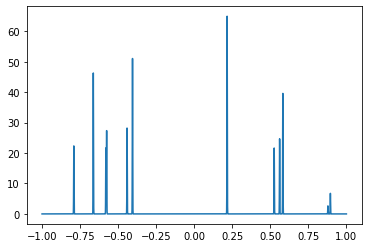

In [207]:
kde_ = hashMap_kde['54535*Customer#000054535*6624.35*13-881-685-9450*CANADA*FS4 tYKNVHKhcA3pe1WrWUBZCo0NqF3*, regular packages wake final requests. express pinto beans are slyly. asymptotes boost carefully alon']\
['revenue']
kde_.set_bandwidth(.002)
x_plot = np.linspace(-1, 1, 5000)
plt.plot(x_plot, [kde_.evaluate(x) for x in x_plot])

l_date, r_date = transform['date'](THE_DATE), transform['date'](THE_DATE + timedelta(days = 90))
kde_ .integrate_box_1d(l_date, r_date)


In [252]:
calculate_error(weighted_kde_result, exact_result).revenue.values

array([2.55674258e-06, 5.51728477e-07, 2.44636652e-03])

### Error

In [122]:
weighted_kde_error = calculate_error(weighted_kde_result, exact_result)
ERROR[1] = (weighted_kde_error.mean(), weighted_kde_error.mean())

In [123]:
weighted_kde_error.revenue.unique()

array([nan])

# Effect of the number of groups

In [266]:
def effect_of_groups(groups):
    error_bank, time_bank = [], []
    for g in groups:
        print(g)
        df = sample_groups(DF, g).cache()
        
        df_clean = df.withColumn('o_orderdate', f.to_date('o_orderdate', 'yyyy-MM-dd'))\
            .withColumn('l_extendedprice', f.col('l_extendedprice').cast('float'))\
            .withColumn('l_discount', f.col('l_discount').cast('float'))
        
        start = timeit.default_timer()
        strata_catalogue, hashMap_kde = kde_based_method_construction(df_clean)
        strata_catalogue = strata_catalogue.cache(); strata_catalogue.count()
        stop = timeit.default_timer()
        cons_time = stop - start
        
        
        start = timeit.default_timer()
        weighted_kde_result = kde_based_method_testing(strata_catalogue, hashMap_kde, THE_DATE, .002).cache(); weighted_kde_result.count()
        stop = timeit.default_timer()
        exe_time = stop - start
        
        start = timeit.default_timer()
        exact_result = compute_exact_result(df, THE_DATE).cache(); exact_result.count()
        stop = timeit.default_timer()
        exact_time = stop - start
        
        errors = calculate_error(weighted_kde_result, exact_result).dropna().revenue.values
        
        time_bank.append([cons_time, exe_time, exact_time])
        error_bank.append([np.mean(errors), np.std(errors)])
#         return errors
    return error_bank, time_bank
    

In [267]:
groups = range(1020, 10000, 1000)
error_bank, time_bank = effect_of_groups(groups)

1020
2020
3020
4020
5020
6020
7020
8020
9020


Text(0, 0.5, 'Relative Error')

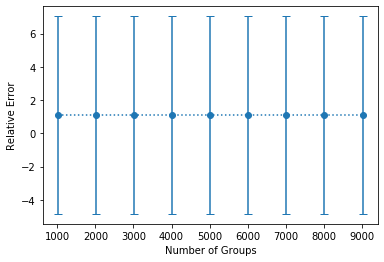

In [268]:
# Error
plt.figure(figsize=(6, 4))
plt.errorbar(groups, [mean for mean, std in error_bank], fmt="o:", \
             yerr=[std for mean, std in error_bank], capsize=4)
plt.xlabel('Number of Groups')
plt.ylabel('Relative Error')
# plt.savefig('./figs/error_groups.png')

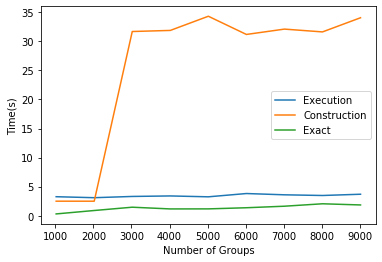

In [276]:
plt.figure(figsize=(6, 4))
plt.plot(groups, np.array(time_bank)[:,1], label='Execution')
plt.plot(groups, np.array(time_bank)[:,0], label='Construction')
plt.plot(groups, np.array(time_bank)[:,2], label='Exact')
plt.legend(loc='center right')
plt.xlabel('Number of Groups')
plt.ylabel('Time(s)')
plt.savefig('./figs/time_groups.png')

In [270]:
error_bank

[[1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775],
 [1.095827842472591, 5.9433225046983775]]